# 1. Introdução e Metadados

Este notebook realiza a análise exploratória (camada Bronze) do dataset Olist (ecommerce brasileiro). O objetivo é reproduzir o estilo e rigor do notebook de referência (Airbnb) aplicado ao contexto dos CSVs do repositório.

### 1.1 Fontes e Contexto
- **Data Source:** Kaggle - Brazilian E-Commerce Public Dataset by Olist
- **URL:** https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
- **Fonte dos dados:** Conjunto de CSVs fornecidos pelo repositório Olist (pasta `DataLayer/raw`).
- **Escopo:** Exploraremos pedidos, itens, pagamentos, avaliações, clientes, produtos, vendedores e geolocalização para entender qualidade, duplicatas, formatos e distribuições principais.

### 1.2 Estrutura esperada
- `orders`: pedidos e timestamps
- `items`: itens por pedido (product_id, price, freight)
- `payments`: formas e valores de pagamento
- `reviews`: avaliações e notas
- `customers`, `products`, `sellers`, `geolocation`

### 1.3 Observações sobre qualidade
- Este notebook prioriza diagnósticos de qualidade (valores ausentes, duplicados, tipos incorretos) e visualizações analogas ao notebook de referência (anotações e percentuais nas figuras).
- As células a seguir carregam os CSVs e executam checks replicando o estilo do exemplo do Airbnb, mas aplicado aos seus dados.
- Esses são dados comerciais reais, foram anonimizados e as referências às empresas e parceiros no texto da análise foram substituídas pelos nomes das grandes casas de Game of Thrones.

**Atenção**

- Um pedido pode ter vários itens.

- Cada item pode ser atendido por um vendedor diferente.

- Todos os textos que identificam lojas e parceiros foram substituídos pelos nomes das grandes casas de Game of Thrones.

**Esquema de dados:**

![alt text](../assets/image.png)


## 2. Análise Exploratória
A seguir, utilizaremos Python para auxiliar na análise dos dados brutos. Com a biblioteca Pandas, podemos visualizar e alterar os dados utilizando Dataframes e Series. Uma Series é um array unidimensional, e um Dataframe é como uma tabela, em que cada coluna é uma Series.

Além dessas bibliotecas, também podemos usar a seaborn para desenhar gráficos com base nos dados das Series e Dataframes.

### 2.1 Importação das bibliotecas e carregamento do Dataset


In [2]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path


### 2.2 Carregamento Automático de Dataset

O código abaixo automatiza a importação de todos os arquivos de dados brutos (.csv) presentes no diretório atual (./raw).

Ele utiliza:

- `glob.glob('./*.csv')`: Para encontrar todos os arquivos CSV.

- `os.path.basename` e .`replace`: Para criar um nome de tabela limpo (sem o .csv).

- Dicionário `dataframes`: Todos os DataFrames são carregados e armazenados neste dicionário, onde a chave é o nome da tabela e o valor é o DataFrame do Panda

In [3]:
dataframes = {}
file_pattern = './*.csv' 
csv_files = glob.glob(file_pattern)
print(f"Arquivos CSV encontrados: {len(csv_files)}")

for file_path in csv_files:
    # Obtém o nome limpo para usar como chave do dicionário
    file_name = os.path.basename(file_path) 
    table_name = file_name.replace('.csv', '')

    try:
    # Carrega o CSV. low_memory=False para garantir tipos de coluna corretos.
        print(f"Carregando: {file_name}")
        df = pd.read_csv(file_path, sep=",", encoding='utf8', low_memory=False)

        # Armazena no df no dicionário
        dataframes[table_name] = df
        print(f"   -> {table_name} carregado com {df.shape[0]} linhas.")

    except Exception as e:
        print(f"ERRO ao carregar {file_name}: {e}")
        
print("-" * 30)
print("Carregamento concluído.")
print(f"DataFrames carregados ({len(dataframes)}): {list(dataframes.keys())}")


Arquivos CSV encontrados: 9
Carregando: olist_products_dataset.csv
   -> olist_products_dataset carregado com 32951 linhas.
Carregando: olist_geolocation_dataset.csv
   -> olist_geolocation_dataset carregado com 1000163 linhas.
Carregando: product_category_name_translation.csv
   -> product_category_name_translation carregado com 71 linhas.
Carregando: olist_orders_dataset.csv
   -> olist_orders_dataset carregado com 99441 linhas.
Carregando: olist_order_items_dataset.csv
   -> olist_order_items_dataset carregado com 112650 linhas.
Carregando: olist_order_reviews_dataset.csv
   -> olist_order_reviews_dataset carregado com 99224 linhas.
Carregando: olist_customers_dataset.csv
   -> olist_customers_dataset carregado com 99441 linhas.
Carregando: olist_order_payments_dataset.csv
   -> olist_order_payments_dataset carregado com 103886 linhas.
Carregando: olist_sellers_dataset.csv
   -> olist_sellers_dataset carregado com 3095 linhas.
------------------------------
Carregamento concluído.
D

In [4]:
# Acessar o DataFrame de clientes
df_customers = dataframes['olist_customers_dataset']
df_customers.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
# Acessar o DataFrame de pedidos
df_orders = dataframes['olist_orders_dataset']
df_orders.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


### 2.3 Dimensões do Dataset

In [6]:
## Verificação das Dimensões de Todos os Datasets

print("--- DIMENSÕES DE TODOS OS DATASETS CARREGADOS ---")
print("-" * 50)

# Itera sobre o dicionário 'dataframes'. 
# 'nome_tabela' será a chave (ex: 'olist_customers_dataset') e 'df' o valor (o DataFrame)
for nome_tabela, df in dataframes.items():
    
    # Obtém o número de linhas e colunas usando a desestruturação (unpacking)
    linhas, colunas = df.shape
    
    # Imprime os resultados de forma formatada
    print(f" {nome_tabela.ljust(20)}\n ")
    print(f" {'Linhas (Tuplas):'.ljust(20)} -> {str(linhas).rjust(5)} ")
    print(f" {'Colunas:'.ljust(20)} -> {str(colunas).rjust(5)} ")
    print("-" * 50)

--- DIMENSÕES DE TODOS OS DATASETS CARREGADOS ---
--------------------------------------------------
 olist_products_dataset
 
 Linhas (Tuplas):     -> 32951 
 Colunas:             ->     9 
--------------------------------------------------
 olist_geolocation_dataset
 
 Linhas (Tuplas):     -> 1000163 
 Colunas:             ->     5 
--------------------------------------------------
 product_category_name_translation
 
 Linhas (Tuplas):     ->    71 
 Colunas:             ->     2 
--------------------------------------------------
 olist_orders_dataset
 
 Linhas (Tuplas):     -> 99441 
 Colunas:             ->     8 
--------------------------------------------------
 olist_order_items_dataset
 
 Linhas (Tuplas):     -> 112650 
 Colunas:             ->     7 
--------------------------------------------------
 olist_order_reviews_dataset
 
 Linhas (Tuplas):     -> 99224 
 Colunas:             ->     7 
--------------------------------------------------
 olist_customers_dataset
 
 Li

## 2.4 Identificação das Colunas e Tipos de Dados

Depois de reconhecer as dimenções gerais de cada csv vamos fazer uma analise mais aprofundada das colunas e dos tipos de dados que temos.

In [7]:
for nome_tabela, df in dataframes.items():

    print("\n\n")
    print("-" * 70)
    print(f"TABELA: {nome_tabela.upper()}")
    print("-" * 70)

    #colunas
    print(df.columns)
    





----------------------------------------------------------------------
TABELA: OLIST_PRODUCTS_DATASET
----------------------------------------------------------------------
Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')



----------------------------------------------------------------------
TABELA: OLIST_GEOLOCATION_DATASET
----------------------------------------------------------------------
Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')



----------------------------------------------------------------------
TABELA: PRODUCT_CATEGORY_NAME_TRANSLATION
----------------------------------------------------------------------
Index(['product_category_name', 'product_category_name_english'], dtype

#### Agora que ja vismos as colunas vamos verificar os tipos de dados(dtypes) que temos

In [8]:
for nome_tabela, df in dataframes.items():
      
    print("\n\n")
    print("-" * 70)
    print(f"TABELA: {nome_tabela.upper()}")
    print("-" * 70)

  # tipos de dados
    print(df.dtypes)




----------------------------------------------------------------------
TABELA: OLIST_PRODUCTS_DATASET
----------------------------------------------------------------------
product_id                     object
product_category_name          object
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object



----------------------------------------------------------------------
TABELA: OLIST_GEOLOCATION_DATASET
----------------------------------------------------------------------
geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object



----------------------------------------------------------------------
TABELA

A análise dos dtypes e das colunas revela que, embora muitos tipos estejam corretos (IDs como object, valores como float), há um problema sistêmico com a interpretação de colunas de tempo e de localização. O problema principal é:

- Datas Incorretas (Tipo Object): Todas as colunas que representam datas e tempo, presentes nas tabelas `OLIST_ORDERS_DATASET`, `OLIST_ORDER_ITEMS_DATASET` e `OLIST_ORDER_REVIEWS_DATASET`, foram classificadas incorretamente como object (texto/string). 


## 2.5 Qualidade dos Dados


### 2.5.1 Análise de Valores Ausentes (Nulos/NaN)


### Análise da Qualidade dos Dados dos Datasets Olist

Ao inspecionar todos os DataFrames do projeto Olist percebemos a presença de valores nulos significativos em três tabelas.

#### Integridade dos Dados (Valores Ausentes)

A maioria dos datasets, incluindo `Clientes`, `Geolocalização`, `Itens do Pedido`, `Pagamentos`, `Vendedores` e `Tradução de Categorias`, está completamente preenchida, sem a presença de valores nulos (NaNs). Os problemas de dados ausentes estão concentrados em:

- Avaliações (`OLIST_ORDER_REVIEWS_DATASET`): Esta tabela tem a maior lacuna. A coluna de título do comentário (review_comment_title) está vazia em 88.34% dos registros, e a mensagem do comentário (review_comment_message) está vazia em 58.70%. Isso é esperado, pois o preenchimento desses campos é opcional para o cliente, mas exige que os nulos sejam tratados como strings vazias para análise de texto.

- Pedidos (`OLIST_ORDERS_DATASET`): Cerca de 3.00% dos registros (2.980 linhas) possuem alguma data de entrega ausente (order_delivered_customer_date). Essa ausência de data é, na verdade, uma *informação importante* que indica pedidos cancelados, perdidos ou ainda em trânsito. Importante ser analisado

- Produtos (`OLIST_PRODUCTS_DATASET`): Uma pequena parte dos registros, 1.85% (610 linhas), tem o nome da categoria (product_category_name) e as informações de dimensões do produto (*lenght, *description_lenght, product_photos_qty) faltando simultaneamente. Os demais 32.341 produtos estão completos.

In [9]:
for nome_tabela, df in dataframes.items():
    
    print("\n" + "="*80)
    print(f"DIAGNÓSTICO DE COLUNAS PARA: {nome_tabela.upper()}")
    print("="*80)
    
    na_count = df.isnull().sum()
    not_null_count = df.count()
    
    summary_df = pd.DataFrame({ 'Dtype': df.dtypes,'Não Nulos': not_null_count, 'Nulos': na_count, 'Total Linhas': len(df)})
    
    print(summary_df)
    print("\n[Contagem Nulos por Coluna]: ")
    
    nulos_sum = df.isnull().sum().sort_values(ascending=False)
    nulos_sum = nulos_sum[nulos_sum > 0]
    
    if not nulos_sum.empty:
        # Calcula a porcentagem para ser mais informativo
        nulos_perc = (nulos_sum / len(df) * 100).map('{:.2f}%'.format)
        nulos_info_df = pd.DataFrame({
            'Contagem': nulos_sum,
            'Porcentagem': nulos_perc
        })
        print(nulos_info_df)
    else:
        print("-> Nenhum valor nulo encontrado nesta tabela.")

    print("\n")



DIAGNÓSTICO DE COLUNAS PARA: OLIST_PRODUCTS_DATASET
                              Dtype  Não Nulos  Nulos  Total Linhas
product_id                   object      32951      0         32951
product_category_name        object      32341    610         32951
product_name_lenght         float64      32341    610         32951
product_description_lenght  float64      32341    610         32951
product_photos_qty          float64      32341    610         32951
product_weight_g            float64      32949      2         32951
product_length_cm           float64      32949      2         32951
product_height_cm           float64      32949      2         32951
product_width_cm            float64      32949      2         32951

[Contagem Nulos por Coluna]: 
                            Contagem Porcentagem
product_category_name            610       1.85%
product_description_lenght       610       1.85%
product_name_lenght              610       1.85%
product_photos_qty               610    


### 2.5.2 Visualização Unificada de Dados Ausentes

Para obter um panorama completo da qualidade de dados do projeto, o gráfico de barras abaixo combina os percentuais de nulos de **todas as colunas** que contêm dados faltantes em todos os DataFrames.

Esta visualização consolidada facilita a identificação das prioridades de limpeza:

  * **Prioridade Máxima (Vermelho \>50%):** As colunas de comentários de revisão (`review_comment_title` e `review_comment_message`) são opcionais e estão quase inteiramente vazias, exigindo que os nulos sejam tratados como *strings* vazias.
  * **Prioridade Alta (Laranja 10-50%):** Nenhuma coluna nesta faixa.
  * **Prioridade Média (Azul \<10%):** As datas de entrega e envio dos pedidos (`order_delivered_customer_date`, `order_delivered_carrier_date`) e as informações de categoria/dimensão de alguns produtos representam as lacunas estruturais do negócio (como pedidos que não foram concluídos ou produtos sem especificações).


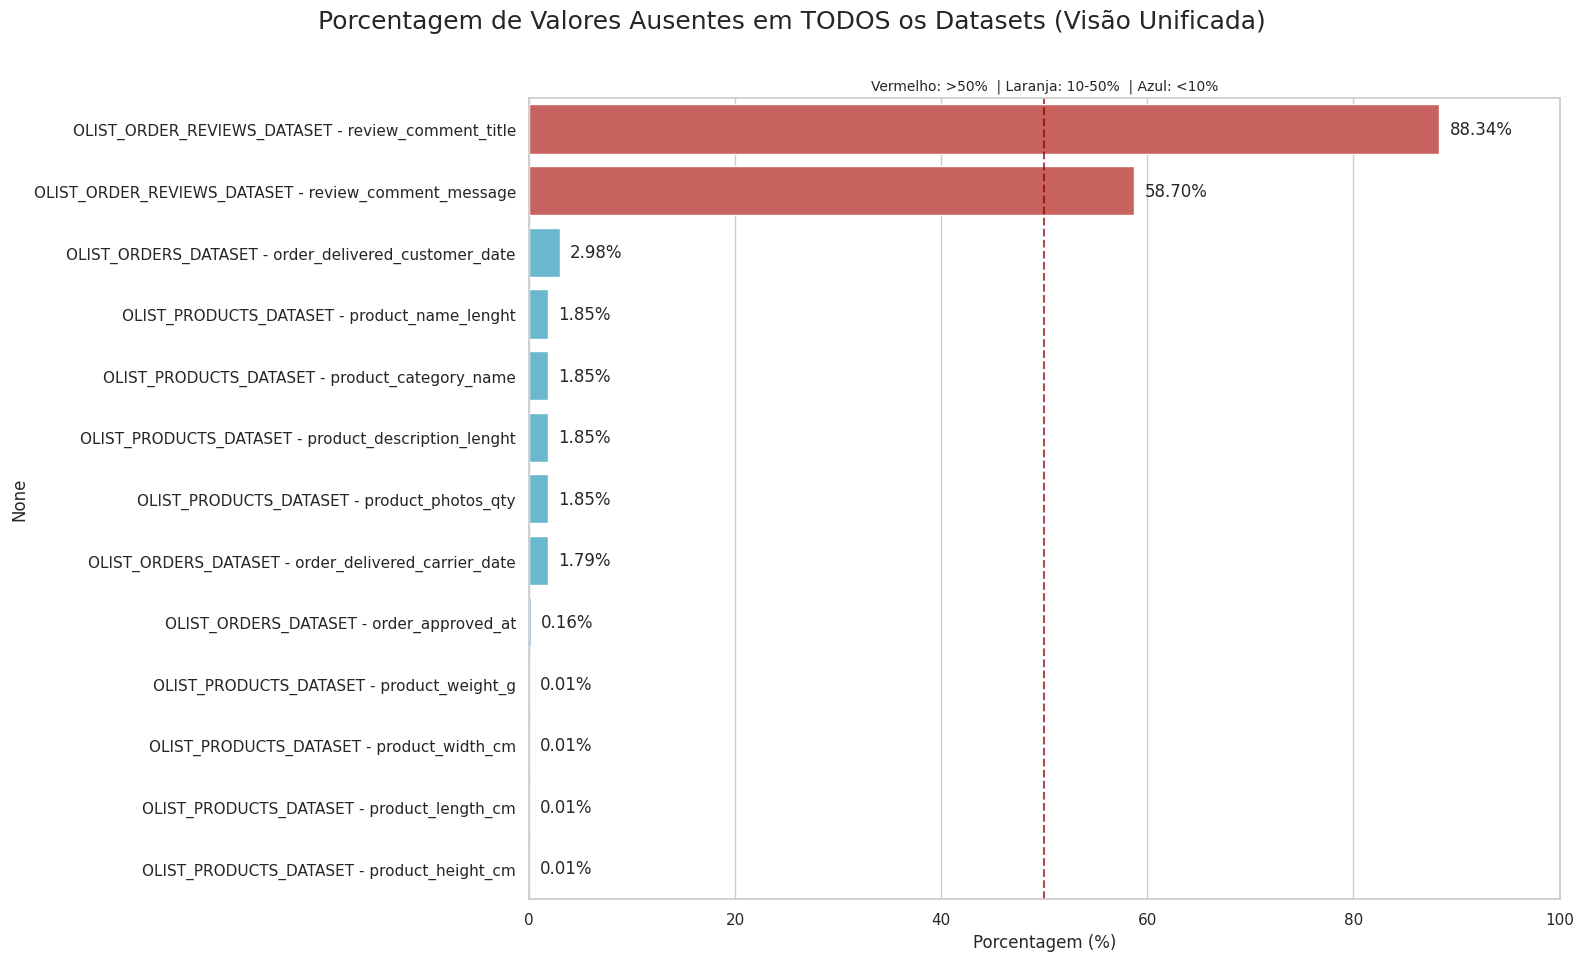

In [10]:
resumo_nulos_global = {}

# Calcula o percentual de nulos de todas as colunas em todos os DataFrames
for nome_tabela, df in dataframes.items():
    null_perc_df = (df.isnull().sum() / len(df) * 100)
    null_perc_df = null_perc_df[null_perc_df > 0] # Filtra colunas com nulos

    # Adiciona prefixo da tabela ao nome da coluna
    for col, perc in null_perc_df.items():
        resumo_nulos_global[f"{nome_tabela.upper()} - {col}"] = perc

null_perc_global = pd.Series(resumo_nulos_global).sort_values(ascending=False)

if not null_perc_global.empty:
    colors = [
        '#d9534f' if v > 50 else '#f0ad4e' if v > 10 else '#5bc0de' 
        for v in null_perc_global.values
    ]
    
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(16, max(10, len(null_perc_global) * 0.7))) 
    
    ax = sns.barplot(
        x=null_perc_global.values, 
        y=null_perc_global.index, 
        hue=null_perc_global.index, 
        palette=colors, 
        legend=False
    )
    
    plt.suptitle("Porcentagem de Valores Ausentes em TODOS os Datasets (Visão Unificada)", fontsize=18, y=0.96)
    ax.set_title("Vermelho: >50%  | Laranja: 10-50%  | Azul: <10%", fontsize=10)
    ax.set_xlabel("Porcentagem (%)")
    ax.set_xlim(0, 100)
    
    # Adiciona rótulos de porcentagem
    for p in ax.patches:
        w = p.get_width()
        ax.text(w + 1, p.get_y() + p.get_height()/2, f'{w:.2f}%', va='center')
        
    ax.axvline(50, color='darkred', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
else:
    print("Nenhum valor nulo encontrado nos datasets para plotagem.")

### 2.5.2 Identificação de Registros Duplicados
Agora, iremos fazer uma varredura em dodos os dados de todos os .cvs para verificar a existência de registros duplicados.

In [11]:
resumo_duplicatas_global = {}

print("--- ANÁLISE DE DUPLICATAS (LINHAS INTEIRAS) EM TODOS OS DATASETS ---")

# 1. Total de tuplas com ID's duplicados e 2. Proporção
for nome_tabela, df in dataframes.items():
    
    total = len(df)
    dups = df.duplicated().sum() 
    
    print("\n" + "="*80)
    print(f"{nome_tabela.upper()}:\n")

    print(f"Total de linhas: {total}")
    print(f"Total de duplicatas (linhas idênticas): {dups}")
    
    if dups > 0:
        perc_dups = (dups / total) * 100
        print(f"Porcentagem de duplicatas: {perc_dups:.4f}%")

        resumo_duplicatas_global[nome_tabela] = {'dups': dups, 'total': total}

    else:
        print("-> Nenhum registro duplicado encontrado nesta tabela.")

--- ANÁLISE DE DUPLICATAS (LINHAS INTEIRAS) EM TODOS OS DATASETS ---

OLIST_PRODUCTS_DATASET:

Total de linhas: 32951
Total de duplicatas (linhas idênticas): 0
-> Nenhum registro duplicado encontrado nesta tabela.

OLIST_GEOLOCATION_DATASET:

Total de linhas: 1000163
Total de duplicatas (linhas idênticas): 261831
Porcentagem de duplicatas: 26.1788%

PRODUCT_CATEGORY_NAME_TRANSLATION:

Total de linhas: 71
Total de duplicatas (linhas idênticas): 0
-> Nenhum registro duplicado encontrado nesta tabela.

OLIST_ORDERS_DATASET:

Total de linhas: 99441
Total de duplicatas (linhas idênticas): 0
-> Nenhum registro duplicado encontrado nesta tabela.

OLIST_ORDER_ITEMS_DATASET:

Total de linhas: 112650
Total de duplicatas (linhas idênticas): 0
-> Nenhum registro duplicado encontrado nesta tabela.

OLIST_ORDER_REVIEWS_DATASET:

Total de linhas: 99224
Total de duplicatas (linhas idênticas): 0
-> Nenhum registro duplicado encontrado nesta tabela.

OLIST_CUSTOMERS_DATASET:

Total de linhas: 99441
Tota

#### Visualização da Proporção de Duplicatas (Global)
O código abaixo plota o resultado da contagem de duplicatas em um único gráfico de barras para aqueles datasets que as contêm.

Podemos observar que a tabela `OLIST_GEOLOCATION_DATASET` `´e a *única* tabela com duplicatas(26.18% das linhas, mais de 261mil registros)

O alto número de duplicatas na tabela OLIST_GEOLOCATION_DATASET é esperado e normal para dados de geolocalização baseados em CEP:

1. *Muitos coordenadas por CEPs*: O mesmo prefixo de CEP aparece várias vezes com Latitudes e Longitudes ligeiramente diferentes, o que é normal, pois um CEP representa uma área, não um ponto único.

2. *Inconsistência de Texto*: Existem erros de padronização, como o nome de cidades registrado com e sem acento (ex: niterói vs niteroi), o que exige uma etapa de normalização de strings.

In [12]:
import pandas as pd

df_geo = dataframes['olist_geolocation_dataset']

print("--- AMOSTRA DAS DUPLICATAS NA TABELA DE GEOLOCALIZAÇÃO ---\n")

# Identifica as duplicatas. 
# keep=False marca TODAS as ocorrências de um registro duplicado (incluindo o original).
is_duplicated = df_geo.duplicated(keep=False)

amostra_duplicatas = df_geo[is_duplicated]

print(amostra_duplicatas.head(10))

print("\n--- CEP MAIS REPETIDO NA AMOSTRA ---")
top_cep_duplicado = amostra_duplicatas['geolocation_zip_code_prefix'].value_counts().head(1)
top_cep = top_cep_duplicado.index[0]

print(f"Ocorrências do CEP mais repetido ({top_cep}):")
print(df_geo[df_geo['geolocation_zip_code_prefix'] == top_cep].head())

--- AMOSTRA DAS DUPLICATAS NA TABELA DE GEOLOCALIZAÇÃO ---

    geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                          1037       -23.545621       -46.639292   
1                          1046       -23.546081       -46.644820   
2                          1046       -23.546129       -46.642951   
6                          1047       -23.546273       -46.641225   
7                          1013       -23.546923       -46.634264   
8                          1029       -23.543769       -46.634278   
9                          1011       -23.547640       -46.636032   
10                         1013       -23.547325       -46.634184   
13                         1012       -23.548946       -46.634671   
15                         1046       -23.546081       -46.644820   

   geolocation_city geolocation_state  
0         sao paulo                SP  
1         sao paulo                SP  
2         sao paulo                SP  
6         sao paulo 

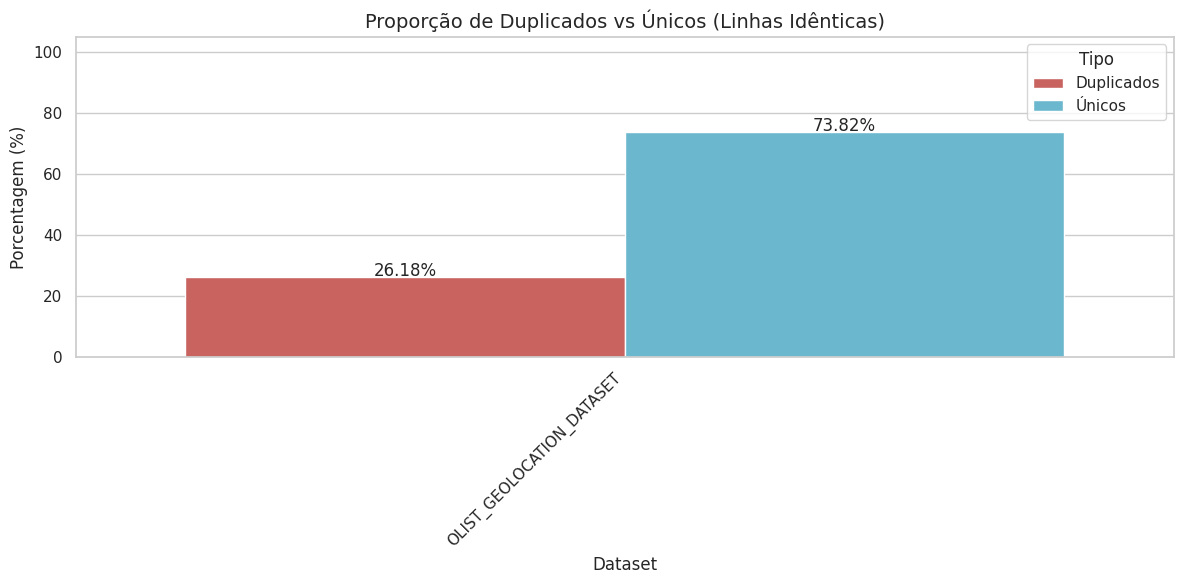

In [13]:
if resumo_duplicatas_global:
    data_list = []
    for nome, data in resumo_duplicatas_global.items():
        dups = data['dups']
        total = data['total']
        
        data_list.append([nome.upper(), 'Duplicados', (dups / total) * 100])
        data_list.append([nome.upper(), 'Únicos', ((total - dups) / total) * 100])

    stats = pd.DataFrame(data_list, columns=['Dataset', 'Tipo', 'Porcentagem'])
    
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6))
    
    dataset_order = stats.sort_values(by='Porcentagem', ascending=False)['Dataset'].unique()

    ax = sns.barplot(data=stats, x="Dataset", y="Porcentagem", hue="Tipo", palette={"Duplicados": "#d9534f", "Únicos": "#5bc0de"}, order=dataset_order)
    
    for p in ax.patches:
        h = p.get_height()
        if h > 0.1:
            ax.text(p.get_x() + p.get_width() / 2, h + 0.5, f"{h:.2f}%", ha="center")
            
    ax.set_title("Proporção de Duplicados vs Únicos (Linhas Idênticas)", fontsize=14)
    ax.set_ylabel("Porcentagem (%)")
    plt.ylim(0, 105)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [14]:
df_customers = dataframes['olist_geolocation_dataset']
df_customers.head(10)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
5,1012,-23.547762,-46.635361,são paulo,SP
6,1047,-23.546273,-46.641225,sao paulo,SP
7,1013,-23.546923,-46.634264,sao paulo,SP
8,1029,-23.543769,-46.634278,sao paulo,SP
9,1011,-23.547640,-46.636032,sao paulo,SP


### 2.5.3 Resumo Estatístico Descritivo das Colunas
Esta etapa ajuda a entender a distribuição, a dispersão e a escala dos dados numéricos.

In [15]:
df_products = dataframes['olist_products_dataset']

print("--- RESUMO ESTATÍSTICO PARA OLIST_PRODUCTS_DATASET ---")

# O método .describe() ignora colunas não numéricas automaticamente.
print(df_products.drop(columns=['product_id']).describe().T)

--- RESUMO ESTATÍSTICO PARA OLIST_PRODUCTS_DATASET ---
                              count         mean          std  min    25%  \
product_name_lenght         32341.0    48.476949    10.245741  5.0   42.0   
product_description_lenght  32341.0   771.495285   635.115225  4.0  339.0   
product_photos_qty          32341.0     2.188986     1.736766  1.0    1.0   
product_weight_g            32949.0  2276.472488  4282.038731  0.0  300.0   
product_length_cm           32949.0    30.815078    16.914458  7.0   18.0   
product_height_cm           32949.0    16.937661    13.637554  2.0    8.0   
product_width_cm            32949.0    23.196728    12.079047  6.0   15.0   

                              50%     75%      max  
product_name_lenght          51.0    57.0     76.0  
product_description_lenght  595.0   972.0   3992.0  
product_photos_qty            1.0     3.0     20.0  
product_weight_g            700.0  1900.0  40425.0  
product_length_cm            25.0    38.0    105.0  
product_he

### 2.5.4 Valores Inconsistentes (Outliers Negativos)

Esta etapa varre as colunas numéricas em todos os DataFrames em busca de valores negativos, que seriam erros óbvios de dados (ex: peso ou preço negativo).

In [16]:
print("\n--- VERIFICAÇÃO DE VALORES INCONSISTENTES (NEGATIVOS) ---")

contagem_negativos_global = {}

# Verifica valores negativos em todas as colunas numéricas de todos os DataFrames
for nome_tabela, df in dataframes.items():
    df_numeric = df.select_dtypes(include=np.number)
    contagem_negativos = (df_numeric < 0).sum()
    colunas_e_contagem = contagem_negativos[contagem_negativos > 0]
    
    if not colunas_e_contagem.empty:
        for col, count in colunas_e_contagem.items():
            contagem_negativos_global[f"{nome_tabela.upper()} - {col}"] = count

print("Contagem de valores negativos por coluna (em todos os datasets):")

if contagem_negativos_global:
    series_negativos = pd.Series(contagem_negativos_global).sort_values(ascending=False)
    print(series_negativos)
else:
    print("-> Nenhum valor negativo (inconsistente) encontrado nas colunas numéricas.")


--- VERIFICAÇÃO DE VALORES INCONSISTENTES (NEGATIVOS) ---
Contagem de valores negativos por coluna (em todos os datasets):
OLIST_GEOLOCATION_DATASET - geolocation_lng    1000160
OLIST_GEOLOCATION_DATASET - geolocation_lat     998827
dtype: int64


## 3. Plotagem de gráficos

### 3.1 Scatter Plot (Gráfico de Dispersão)  - **Preço do Item vs. Valor do Frete**

Este gráfico mostra a relação entre o Preço do Item e o Valor do Frete.

O gráfico de dispersão mostra que:


**Concentração**: A vasta maioria dos dados (comportamento normal) se agrupa em Preços e Fretes baixos (canto inferior esquerdo).

**Outliers**: A presença de pontos isolados e extremos em Preços altos (acima de R$3000) e Fretes altos domina a visualização.

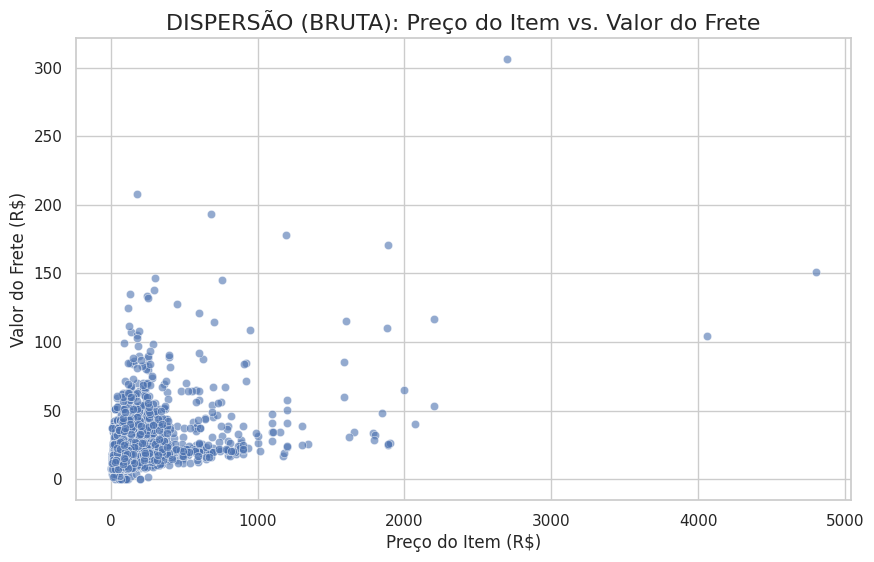

In [17]:
df_items = dataframes['olist_order_items_dataset']

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='price', 
    y='freight_value', 
    data=df_items.sample(n=5000, random_state=42), 
    alpha=0.6
)
plt.title('DISPERSÃO (BRUTA): Preço do Item vs. Valor do Frete', fontsize=16)
plt.xlabel('Preço do Item (R$)')
plt.ylabel('Valor do Frete (R$)')
plt.show()

### 3.2 Regressão Linear - **Preço do Item vs. Valor do Frete**
A Regressão Linear traça uma linha de melhor ajuste para prever o Frete com base no Preço.
O gráfico de Frete vs. Volume  também mostra uma forte correlação positiva.

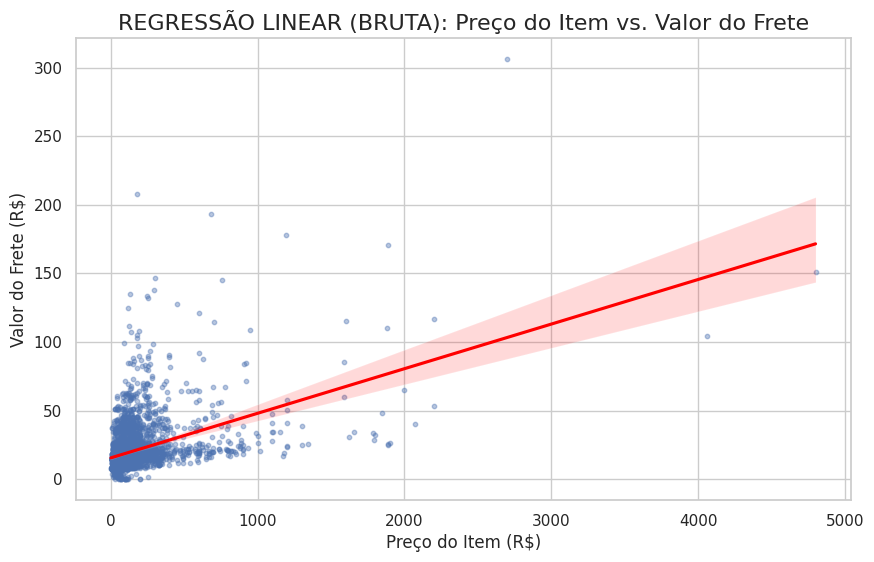

In [18]:
plt.figure(figsize=(10, 6))
sns.regplot(
    x='price', 
    y='freight_value', 
    data=df_items.sample(n=5000, random_state=42), # Usamos a mesma amostra
    scatter_kws={'alpha': 0.4, 's': 10}, 
    line_kws={'color': 'red'} 
)
plt.title('REGRESSÃO LINEAR (BRUTA): Preço do Item vs. Valor do Frete', fontsize=16)
plt.xlabel('Preço do Item (R$)')
plt.ylabel('Valor do Frete (R$)')
plt.show()

### 3.3 Matriz de Correlação (Substituindo a Matriz de Confusão)
Este gráfico exibe o quão correlacionadas estão as medidas físicas dos produtos entre si (Peso, Altura, Comprimento e Largura).

O principal achado é a forte correlação entre o Peso e as Dimensões (comprimento, altura, largura). Isso é uma indicação clara de Multicolinearidade.
As medidas físicas são fortemente correlacionadas entre si. Produtos mais pesados tendem a ser maiores. Isso indica Multicolinearidade na futura fase de Modelagem.
Não há relação entre o tamanho do nome ou descrição do produto e seu peso/dimensão física.

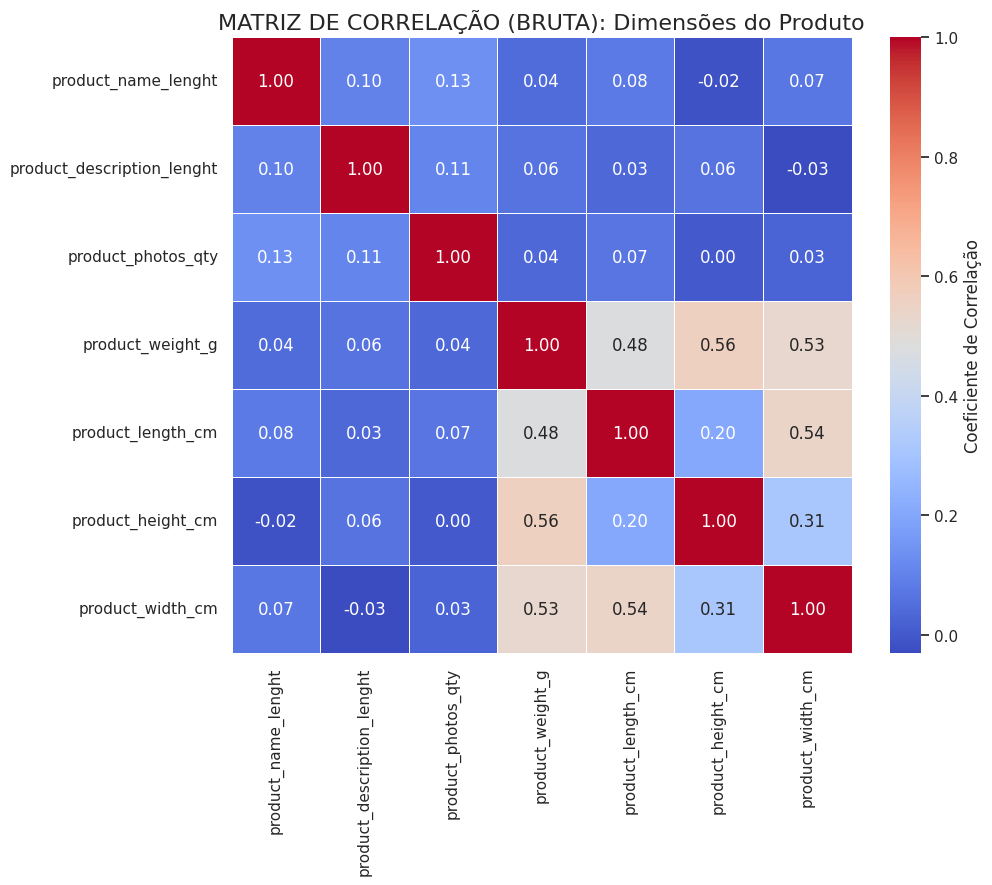

In [19]:
df_products = dataframes['olist_products_dataset']

# Selecionamos apenas colunas numéricas (incluindo as que têm nulos)
numeric_cols = df_products.select_dtypes(include=['float64', 'int64']).columns
df_corr = df_products[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    df_corr, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=.5, 
    cbar_kws={'label': 'Coeficiente de Correlação'}
)
plt.title('MATRIZ DE CORRELAÇÃO (BRUTA): Dimensões do Produto', fontsize=16)
plt.show()

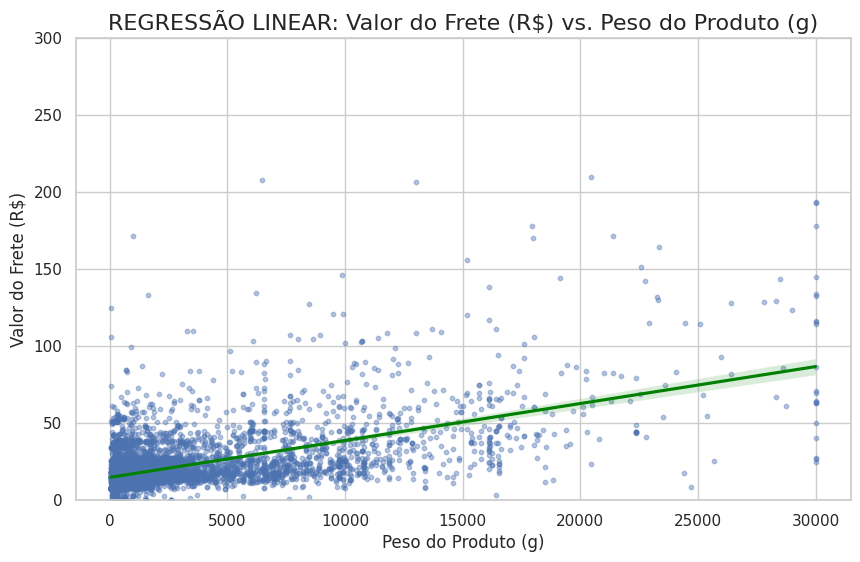

In [20]:
df_items = dataframes['olist_order_items_dataset']
df_products = dataframes['olist_products_dataset']

# Merge  (Frete) e (Dimensões/Peso)
df_frete_dimensoes = pd.merge( df_items, df_products[['product_id', 'product_weight_g']],on='product_id',  how='left')
df_amostra = df_frete_dimensoes.sample(n=10000, random_state=42)

plt.figure(figsize=(10, 6))
sns.regplot( x='product_weight_g', y='freight_value', data=df_amostra,scatter_kws={'alpha': 0.4, 's': 10}, line_kws={'color': 'green'} )

plt.title('REGRESSÃO LINEAR: Valor do Frete (R$) vs. Peso do Produto (g)', fontsize=16)
plt.xlabel('Peso do Produto (g)')
plt.ylabel('Valor do Frete (R$)')
plt.ylim(0, 300) 
plt.show()

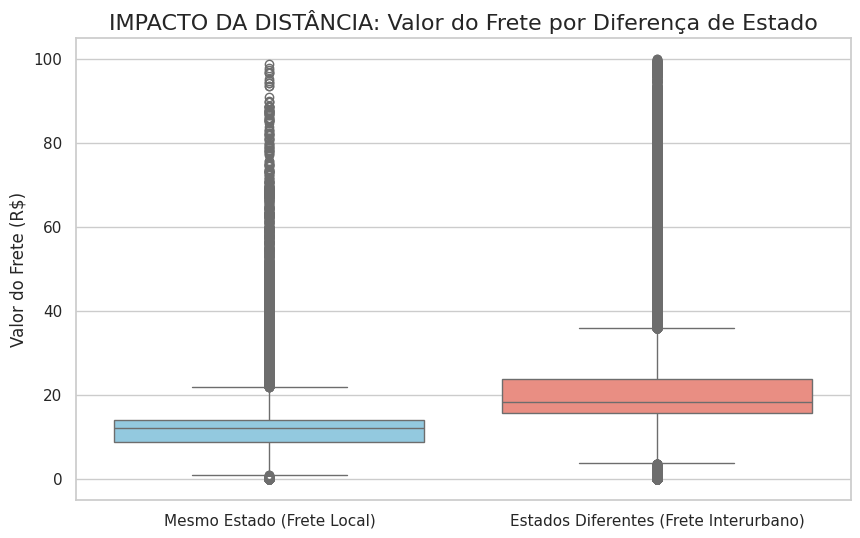

In [21]:
# unindo as tabelas para obter Frete, Cliente e Vendedor
df_orders = dataframes['olist_orders_dataset']
df_customers = dataframes['olist_customers_dataset']
df_sellers = dataframes['olist_sellers_dataset']
df_items = dataframes['olist_order_items_dataset'] # Para o valor do frete

df_temp = pd.merge(df_orders, df_customers[['customer_id', 'customer_state']], on='customer_id', how='left')
df_temp = pd.merge(df_temp, df_items[['order_id', 'seller_id', 'freight_value']], on='order_id', how='left')
df_frete_estados = pd.merge(df_temp, df_sellers[['seller_id', 'seller_state']], on='seller_id', how='left')


df_frete_estados['Mesmo_Estado'] = ( df_frete_estados['customer_state'] == df_frete_estados['seller_state']).map({True: 'Mesmo Estado (Frete Local)', False: 'Estados Diferentes (Frete Interurbano)'})

df_plot = df_frete_estados[df_frete_estados['freight_value'] < 100].dropna(subset=['Mesmo_Estado'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='Mesmo_Estado', y='freight_value', data=df_plot, hue='Mesmo_Estado', palette={'Mesmo Estado (Frete Local)': 'skyblue', 'Estados Diferentes (Frete Interurbano)': 'salmon'}, legend=False)

plt.title('IMPACTO DA DISTÂNCIA: Valor do Frete por Diferença de Estado', fontsize=16)
plt.xlabel('')
plt.ylabel('Valor do Frete (R$)')
plt.show()

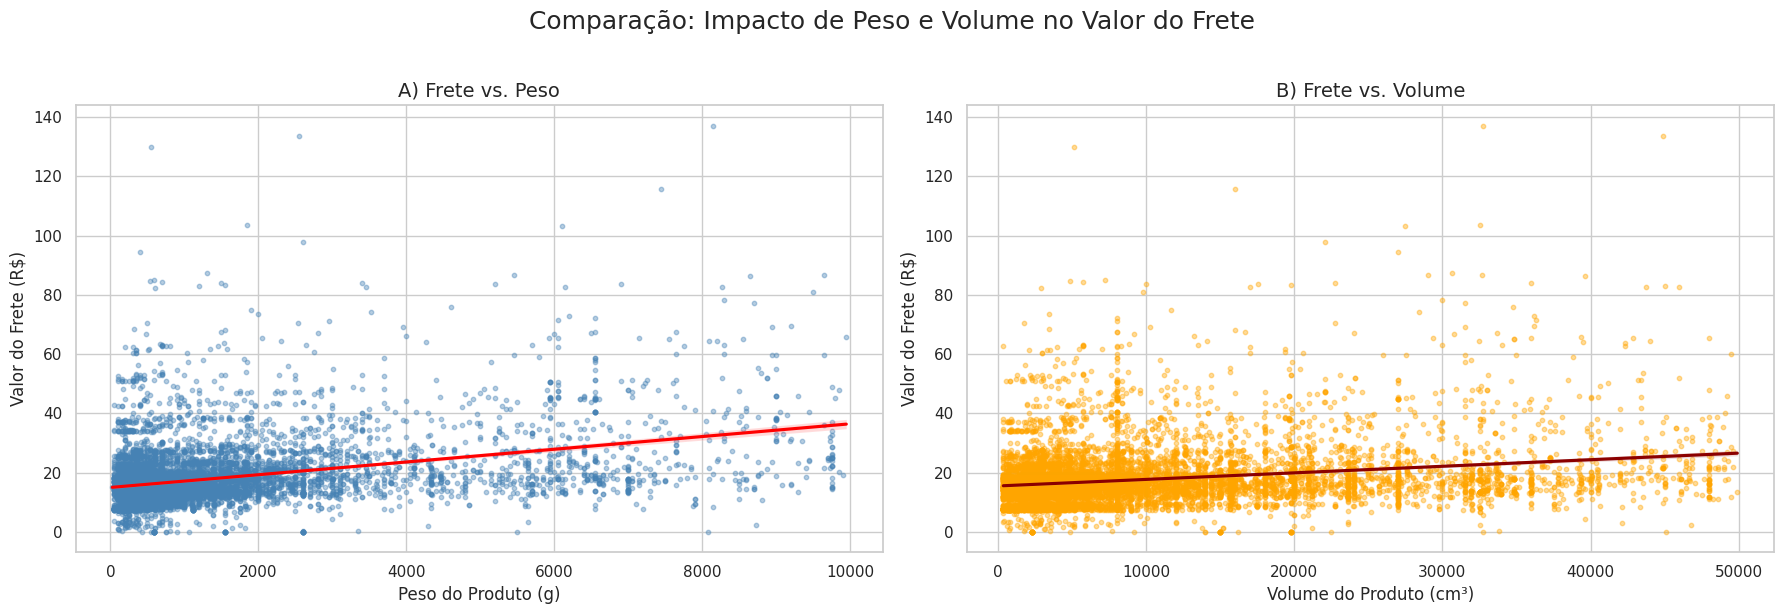

In [22]:
if 'olist_order_items_dataset' in dataframes and 'olist_products_dataset' in dataframes:
    df_items = dataframes['olist_order_items_dataset']
    df_products = dataframes['olist_products_dataset'].copy()

    df_products['Volume_cm3'] = (df_products['product_length_cm'] * df_products['product_height_cm'] * df_products['product_width_cm'])

    df_frete_dimensoes = pd.merge( df_items, df_products[['product_id', 'product_weight_g', 'Volume_cm3']], on='product_id', how='left').dropna()

    df_filtrado = df_frete_dimensoes[
        (df_frete_dimensoes['product_weight_g'] < 10000) & 
        (df_frete_dimensoes['Volume_cm3'] < 50000) & # Filtra volumes muito grandes
        (df_frete_dimensoes['freight_value'] < 200) # Filtra fretes extremos
    ]
    df_amostra = df_filtrado.sample(n=10000, random_state=42)
        
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    plt.suptitle('Comparação: Impacto de Peso e Volume no Valor do Frete', fontsize=18, y=1.02)
    
    # Gráfico A: Regressão do Frete vs. Peso
    sns.regplot(x='product_weight_g',   y='freight_value', data=df_amostra,ax=axes[0], scatter_kws={'alpha': 0.4, 's': 10, 'color': 'steelblue'}, line_kws={'color': 'red'})
    axes[0].set_title('A) Frete vs. Peso', fontsize=14)
    axes[0].set_xlabel('Peso do Produto (g)')
    axes[0].set_ylabel('Valor do Frete (R$)')
    
    # Gráfico B: Regressão do Frete vs. Volume
    sns.regplot(x='Volume_cm3', y='freight_value', data=df_amostra, ax=axes[1], scatter_kws={'alpha': 0.4, 's': 10, 'color': 'orange'}, line_kws={'color': 'darkred'})
    axes[1].set_title('B) Frete vs. Volume', fontsize=14)
    axes[1].set_xlabel('Volume do Produto (cm³)')
    axes[1].set_ylabel('Valor do Frete (R$)')

    plt.tight_layout()
    plt.show()
    

else:
    print("Erro: Os DataFrames necessários não foram encontrados. Certifique-se de que 'dataframes' foi carregado.")